In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd
import datetime as datetime
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///SurfsUp/Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

/var/folders/_y/ln4f07d95w9gbfhx9r78wr240000gn/T/ipykernel_39526/1982011038.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [21]:
# Save references to each table
# View all of the classes that automap found
Measurement = Base.classes.measurement
Station = Base.classes.station


In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = datetime.strptime(latest_date, "%Y-%m-%d")

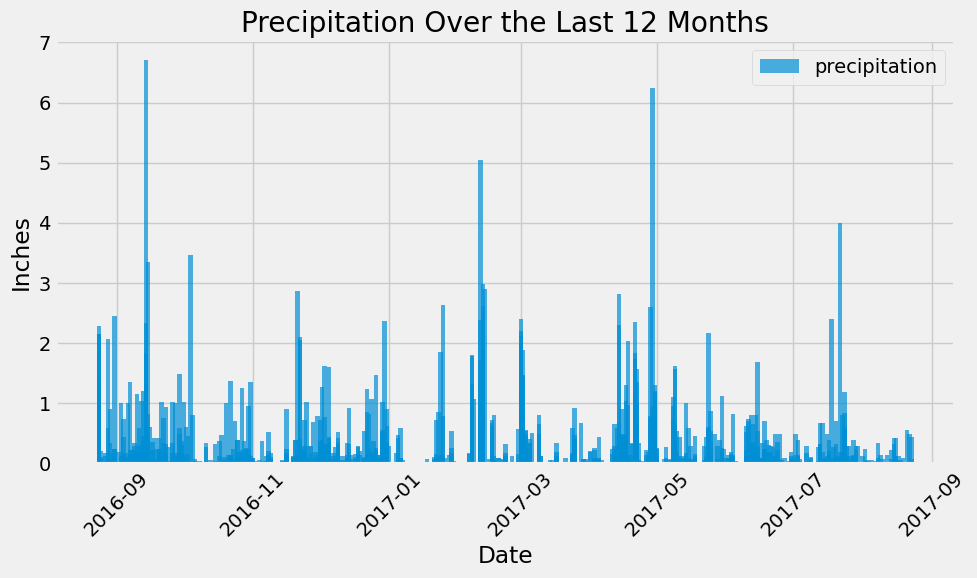

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precip_df.index, precip_df['precipitation'], alpha=0.7, label='precipitation', width=2)
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precip_df['precipitation'].describe()
print(summary_stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()


[(9,)]

In [42]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations (Station ID and Counts):")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Most Active Stations (Station ID and Counts):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]  
temp_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).all()

min_temp, max_temp, avg_temp = temp_stats[0]

print(f"Temperature statistics for the most active station ({most_active_station}):")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Temperature statistics for the most active station (USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


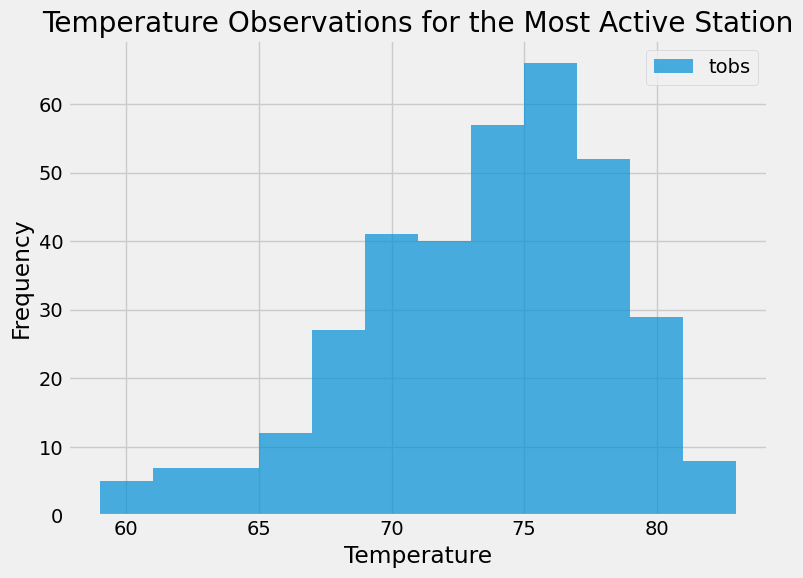

In [45]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()
temperature_values = [temp[0] for temp in temperature_data]

plt.figure(figsize=(8, 6))
plt.hist(temperature_values, bins=12, alpha=0.7, label='tobs')
plt.title("Temperature Observations for the Most Active Station")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


# Close Session

In [46]:
# Close Session
session.close()